### Import Required Libraries

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd /content/drive/My\ Drive/Text
%ls

/content/drive/My Drive/Text
 7_TEXT_TimeSeries_REE_electricity_demand_predictor.ipynb
'Copia de 5_TEXT_DenseNet_Classifying-IMBD-movie-reviews.ipynb'
'Copia de 6_TEXT_RNN_LSTM_Classifying_IMBD_movies_reviews.ipynb'
 deu-eng/
 LAB_TEXT_MachineTranslation_DE_EN.ipynb
 model.h1.24_AP
 model.h1.24_jan_19
 spa-eng/


In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of Español-Ingles sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [0]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [15]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face.', 'Su cara mostraba fatiga.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name.',
        'Pocos estudiantes conocían su nombre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire.', 'Rellena el cuestionario.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [17]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Fatigue showed on her face', 'Su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['Few students knew his name',
        'Pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['Fill out the questionnaire', 'Rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

In [0]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [19]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['fatigue showed on her face', 'su cara mostraba fatiga',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317786 (CM) & #1630578 (teskmon)'],
       ['few students knew his name',
        'pocos estudiantes conocían su nombre',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #287661 (CK) & #1332261 (Shishir)'],
       ['fill out the questionnaire', 'rellena el cuestionario',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4305622 (CK) & #5869213 (albrusgher)']],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [21]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    4    4
49996    6    6
49997    5    4
49998    5    5
49999    4    3

[50000 rows x 2 columns]
8
12


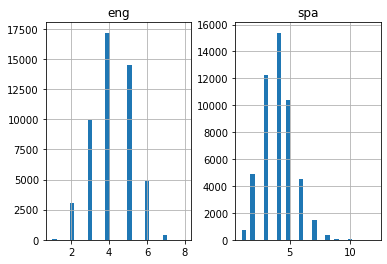

In [22]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [24]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6917


In [25]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14176


In [26]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 114), ('vete', 30), ('vaya', 39), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 383), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('me', 3073), ('oculté', 1), ('escondí', 3), ('ocultaba', 1), ('escondía', 1), ('corrí', 13), ('corría', 4), ('lo', 2129), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5893), ('tomátelo', 2), ('con', 856), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 505), ('mismo', 129), ('id', 7), ('vayan', 11), ('ya', 338), ('¡lo', 10), ('tengo', 883), ('¿lo', 63), ('pillas', 1), ('¿entendi

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [29]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1    2  969 ...   33    0    0]
 [  11   13  728 ... 2951    0    0]
 [  30  486   14 ...  231    0    0]
 ...
 [  10 3406    7 ...    0    0    0]
 [4520   14   40 ... 1504    0    0]
 [  81  381  250 ...    0    0    0]]
40000
[[   3  487   67 ...    0    0    0]
 [   9  327   43 ...    0    0    0]
 [   1   17   70 ...   50    0    0]
 ...
 [   2  327   13 ...    0    0    0]
 [1224  123  755 ...   25    0    0]
 [   1   50    7 ...    0    0    0]]
40000


In [30]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [31]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[1053   84 1197 ...    0    0    0]
 [  22   78   29 ...    0    0    0]
 [  70   20  832 ...    0    0    0]
 ...
 [1267  141   25 ...    0    0    0]
 [  38  240    6 ...    0    0    0]
 [   3  295  157 ...    0    0    0]]
10000
[[ 81  51  34 ...   0   0   0]
 [  1 108  38 ...   0   0   0]
 [ 71 532   2 ...   0   0   0]
 ...
 [ 11   2  26 ...   0   0   0]
 [  2  17 629 ...   0   0   0]
 [  9   4 224 ...   0   0   0]]
10000


In [32]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
def build_model_SimpleRNN(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
# build LSTM model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))   
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [35]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14176
6917
8
8


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [37]:
filename = 'model.h1.24_AP'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 21s 653us/step - loss: 3.7839 - val_loss: 3.3815

Epoch 00001: val_loss improved from inf to 3.38149, saving model to model.h1.24_AP
Epoch 2/30
32000/32000 [==============================] - 19s 587us/step - loss: 3.2215 - val_loss: 3.2006

Epoch 00002: val_loss improved from 3.38149 to 3.20055, saving model to model.h1.24_AP
Epoch 3/30
32000/32000 [==============================] - 19s 586us/step - loss: 3.1110 - val_loss: 3.1493

Epoch 00003: val_loss improved from 3.20055 to 3.14930, saving model to model.h1.24_AP
Epoch 4/30
32000/32000 [==============================] - 19s 592us/step - loss: 2.9861 - val_loss: 3.0326

Epoch 00004: val_loss improved from 3.14930 to 3.03260, saving model to model.h1.24_AP
Epoch 5/30
32000/32000 [==============================] - 19s 589us/step - loss: 2.8816 - val_loss: 2.9473

Epoch 00005: val_loss improved from 3.03260 to 2.94732, saving mode

Let's compare the training loss and the validation loss.

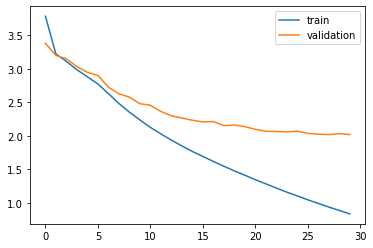

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [39]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [44]:
pred_df.head(15)

actual              predicted
0      so how did this happen        knew a fun     
1                  i eat here   can have ballet     
2              who helped you        the stop  a    
3              smoke appeared              me       
4    they went to new zealand  how tom  a careful   
5    can you explain it to me    with your take     
6   four times five is twenty         go yours      
7    i just wanted to see you        have help      
8           im a little crazy        tom we tom     
9     im sorry for what i did            is an      
10              hes too drunk           a  mary     
11                 tom saw me            i is a     
12              tom was dying    i know changed     
13              this is weird          what is      
14           lets hit the hay    have just hear

In [45]:
pred_df.tail(15)

actual                predicted
9985      you really are nuts           been is a     
9986        they kept running           they tom      
9987    all of these are mine              go it      
9988     youve come too early     give need  quiet    
9989      nobody can stop tom           i is will     
9990      i dont mind waiting    you time changed     
9991       happy thanksgiving      my work my dont    
9992              i loved her          can ive to     
9993  did you come here alone         one  stop it    
9994          were surrounded              we im      
9995    i was very busy today        me ghosts to     
9996    i used to be your age    can  they married    
9997       do you like robots  i yesterday not did    
9998  you have until midnight           that not      
9999     he is hard to please      is tom a flight

In [46]:
pred_df.tail(15)

actual                predicted
9985      you really are nuts           been is a     
9986        they kept running           they tom      
9987    all of these are mine              go it      
9988     youve come too early     give need  quiet    
9989      nobody can stop tom           i is will     
9990      i dont mind waiting    you time changed     
9991       happy thanksgiving      my work my dont    
9992              i loved her          can ive to     
9993  did you come here alone         one  stop it    
9994          were surrounded              we im      
9995    i was very busy today        me ghosts to     
9996    i used to be your age    can  they married    
9997       do you like robots  i yesterday not did    
9998  you have until midnight           that not      
9999     he is hard to please      is tom a flight

In [47]:
pred_df.sample(15)

actual                  predicted
2912       we only did it once       where dogs it he    
8938         this was my fault           car at  life    
6763        this clock is mine           was buy is a    
2251        please wait for me  she tom her school lot   
8679       youre opportunistic           made these      
7673  he advised her not to go        this hot a girl    
10               hes too drunk               a  mary     
8203     i think hes too young      she is your order    
193    tom doesnt trust anyone              i still      
6516                how boring          we tom be hit    
6520              it isnt real           me a unsure     
2725    its about time for bed           that need  a    
8258   this shop belongs to me      didnt well a duty    
989          i seem to be lost         do can doctor     
6107    tom nodded reluctantly           i is the lot